In [1]:
import uuid, sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import math
import random

from sklearn import metrics
from scipy import stats
from collections import Counter

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 3 on the node
print(torch.cuda.get_device_name(0))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
import pytorch_lightning as pl
from torch.optim import AdamW

torch.manual_seed(0)

from accelerate import Accelerator

import matplotlib.pyplot as plt
import seaborn as sns

from Levenshtein import distance as Ldistance

import training_utils.dataset_utils as data_utils
import training_utils.partitioning_utils as pat_utils

import importlib
import training_utils.train_utils as train_utils
importlib.reload(train_utils)

Tesla V100-SXM2-32GB


<module 'training_utils.train_utils' from '/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts/training_utils/train_utils.py'>

In [2]:
SEED = 0
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: s232958 (s232958-danmarks-tekniske-universitet-dtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
os.chdir("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts")
# print(os.getcwd())

print("PyTorch:", torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

PyTorch: 2.5.1
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [5]:
# Model parameters
memory_verbose = False
use_wandb = True # Used to track loss in real-time without printing
model_save_steps = 1
train_frac = 1.0
test_frac = 1.0

embedding_dimension = 1152 # 1280 | 960 | 1152
number_of_recycles = 2
padding_value = -5000

batch_size = 20
learning_rate = 2e-5
EPOCHS = 15

In [6]:
## Model Class
### MiniClip 
# def gaussian_kernel(x, sigma):
#     return np.exp(-x**2 / (2 * sigma**2))

# def transform_vector(vector, sigma):

#     interacting_indices = np.where(vector == 1)[0]   # positions where vector == 1
#     transformed_vector = np.zeros_like(vector, dtype=float)
    
#     for i in range(len(vector)):
#         if vector[i] == 0:
#             distances = np.abs(interacting_indices - i)   # distance to all "1"s
#             min_distance = np.min(distances)              # closest "1"
#             transformed_vector[i] = gaussian_kernel(min_distance, sigma)
#         else:
#             transformed_vector[i] = 1.0
#     return transformed_vector

# def safe_shuffle(n, device):
#     shuffled = torch.randperm(n, device=device)
#     while torch.any(shuffled == torch.arange(n, device=device)):
#         shuffled = torch.randperm(n, device=device)
#     return shuffled

def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=1152, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value
        self.embed_dimension = embed_dimension

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init

        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)  # For residual additions

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input, padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input, padding_value=self.padding_value)
 
        # Initialize residual states
        pep_emb = pep_input.clone()
        prot_emb = prot_input.clone()
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            pep_emb = pep_emb + pep_cross  
            prot_emb = prot_emb + prot_cross

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding))
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding))
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1)
        
        return logits

    def training_step(self, batch, device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        logits = self.forward(embedding_pep, embedding_prot)
        loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
        
        return loss
    
    def validation_step(self, batch, device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        with torch.no_grad():
            logits = self.forward(embedding_pep, embedding_prot)
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
    
        return float(loss), logits, binder_labels

In [7]:
## Output path
trained_model_dir = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts"

## Embeddings paths
binders_embeddings = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings"
targets_embeddings = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings"

# ## Training variables
runID = uuid.uuid4()

def print_mem_consumption():
    # 1. Total memory available on the GPU (device 0)
    t = torch.cuda.get_device_properties(0).total_memory
    # 2. How much memory PyTorch has *reserved* from CUDA
    r = torch.cuda.memory_reserved(0)
    # 3. How much of that reserved memory is actually *used* by tensors
    a = torch.cuda.memory_allocated(0)
    # 4. Reserved but not currently allocated (so “free inside PyTorch’s pool”)
    f = r - a

    print("Total memory: ", t/1e9)      # total VRAM in GB
    print("Reserved memory: ", r/1e9)   # PyTorch’s reserved pool in GB
    print("Allocated memory: ", a//1e9) # actually in use (integer division)
    print("Free memory: ", f/1e9)       # slack in the reserved pool in GB

print_mem_consumption()

Total memory:  34.072559616
Reserved memory:  0.0
Allocated memory:  0.0
Free memory:  0.0


#### Loading data frame

In [8]:
### Loading the dataset
interaction_df = pd.read_csv("../data/meta_analysis/interaction_df_metaanal.csv", index_col = 0).drop(columns = ["binder_id", "target_id"]).rename(columns={
    "A_seq" : "binder_seq",
    "B_seq" : "target_seq"
})

all_targets = interaction_df.target_id_mod.unique()
binder_nonbinder = interaction_df.binder.value_counts()
target_binder_nonbinder_Dict = dict(interaction_df.groupby("target_id_mod")["binder"].value_counts())
sorted_items = sorted(target_binder_nonbinder_Dict.items(), key=lambda kv: kv[1], reverse=True)

# %%
# Annotating each observation with a weight corresponding to whether it is considered a binder or not
N_bins = len(interaction_df["binder"].value_counts())
pr_class_uniform_weight = 1 / N_bins
pr_class_weight_informed_with_size_of_bins = pr_class_uniform_weight  / interaction_df["binder"].value_counts()
pr_class_weight_informed_with_size_of_bins = pr_class_weight_informed_with_size_of_bins.to_dict()
interaction_df["observation_weight"] = interaction_df.binder.apply(lambda x: pr_class_weight_informed_with_size_of_bins[x])
weights_Dict = dict(zip(interaction_df["target_binder_ID"], interaction_df["observation_weight"]))
interaction_df

,binder_chain,target_chains,binder,binder_seq,target_seq,target_id_mod,target_binder_ID,observation_weight
0,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1,0.000159
1,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1,0.000159
2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2,0.000159
3,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3,0.000159
4,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4,0.000159
...,...,...,...,...,...,...,...,...
3527,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62,0.000159
3528,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63,0.000159
3529,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64,0.000159
3530,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65,0.000159


In [9]:
binders_per_target = dict(interaction_df['target_id_mod'].value_counts())
targets = interaction_df['target_id_mod'].unique().tolist()

# 5-fold CV training + weighting of samples

In [10]:
clusters = [
    ["VirB8"], 
    ["FGFR2"], 
    ["IL7Ra"], 
    ["InsulinR"],
    ["EGFR", "EGFR_2", "EGFR_3"],     # keep together
    ["SARS_CoV2_RBD"], 
    ["Pdl1"], 
    ["TrkA"], 
    ["IL10Ra"],
    ["LTK"], 
    ["Mdm2"],
    ["sntx", "sntx_2"],               # keep together
    ["IL2Ra"]]

random.Random(0).shuffle(clusters)
folds = np.array_split(np.array(clusters, dtype=object), 5)   # list of np arrays
targets_folds = []
for f in folds:
    flat = []
    for group in f:
        flat.extend(group)
    targets_folds.append(flat)

def build_cv_splits(targets_folds):
    val_folds, train_folds = [], []
    K = len(targets_folds)
    for i in range(K):
        val_targets = list(targets_folds[i])  # copy
        train_targets = [t for j, fold in enumerate(targets_folds) if j != i for t in fold]
        val_folds.append(val_targets)
        train_folds.append(train_targets)
    return val_folds, train_folds

val_folds, train_folds = build_cv_splits(targets_folds)
cv_splits = list(zip(val_folds, train_folds))

In [11]:
for idx in range(len(cv_splits)):
    val_targets = cv_splits[idx][0]
    vals = len(interaction_df[interaction_df.target_id_mod.isin(val_targets)])
    trains = len(interaction_df) - vals
    print(f"Fold {idx+1} : training instances : {trains}, validation instances : {vals}")

Fold 1 : training instances : 1280, validation instances : 2252
Fold 2 : training instances : 3213, validation instances : 319
Fold 3 : training instances : 3265, validation instances : 267
Fold 4 : training instances : 2999, validation instances : 533
Fold 5 : training instances : 3371, validation instances : 161


### Creating separate targets/ binder dataframes

In [12]:
# Targets df
target_df = interaction_df[["target_id_mod","target_seq"]].rename(columns={"target_seq":"sequence", "target_id_mod" : "ID"})
target_df["seq_len"] = target_df["sequence"].apply(len)
target_df = target_df.drop_duplicates(subset=["ID","sequence"])
target_df = target_df.set_index("ID")

# Binders df
binder_df = interaction_df[["target_binder_ID","binder_seq", "binder"]].rename(columns={"binder_seq":"sequence", "target_binder_ID" : "ID", "binder" : "label"})
binder_df["seq_len"] = binder_df["sequence"].apply(len)
binder_df = binder_df.set_index("ID")
binder_df["observation_weight"] = binder_df.index.map(weights_Dict)

# Interaction Dict
interaction_Dict = dict(enumerate(zip(interaction_df["target_id_mod"], interaction_df["target_binder_ID"]), start=1))

### Creating class for loading binders/targets

In [13]:
class CLIP_meta_analysis_dataset(Dataset):

    def __init__(self, sequence_df, esm_encoding_paths, embedding_dim=1152, padding_value=-5000):

        super(CLIP_meta_analysis_dataset, self).__init__()

        self.sequence_df = sequence_df # target/binder_df
        self.max_length = sequence_df["seq_len"].max()
        self.sequence_df["index_num"] = np.arange(len(self.sequence_df))
        # print(self.sequence_df)
        self.esm_encoding_paths = esm_encoding_paths
        num_samples = len(self.sequence_df)
        
        self.x = torch.full((num_samples, self.max_length, embedding_dim), padding_value, dtype=torch.float32)

        self.accessions = self.sequence_df.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        
        # Load embeddings into the pre-allocated tensor
        all_acc_list = self.accessions
        all_acc_loaded_list = []

        iterator = tqdm(all_acc_list, position=0, leave=True, total=num_samples, desc="# Reading in ESM-embeddings from folder")
        for i, accession in enumerate(iterator):
            npy_path = os.path.join(esm_encoding_paths, f"{accession}.npy")
            try:
                embd = np.load(npy_path)[0]
                length_to_pad = self.max_length - len(embd)
                if length_to_pad > 0:
                    zero_padding = np.ones((length_to_pad, embd.shape[1])) * padding_value
                    padded_array = np.concatenate((embd, zero_padding), axis=0)
                else:
                    padded_array = embd[:self.max_length] 
                self.x[i] = torch.tensor(padded_array, dtype=torch.float32)
                all_acc_loaded_list.append(accession)
            except FileNotFoundError as e:
                raise FileNotFoundError(f"Embedding file {accession}.npy not found.")
            
        missing = sorted(set(all_acc_list) - set(all_acc_loaded_list))
        if missing:
            raise FileNotFoundError(
                f"Missing {len(missing)} embedding files in '{esm_encoding_paths}'. "
                f"Examples: {missing}")
          
    def __len__(self):
        return int(self.x.shape[0])

    def __getitem__(self, idx):
        return self.x[idx]
    
    # add a helper:
    def get_by_name(self, name: str):
        return self.x[self.name_to_row[name]]

targets_dataset = CLIP_meta_analysis_dataset(target_df, esm_encoding_paths="/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings", embedding_dim=1152)
binders_dataset = CLIP_meta_analysis_dataset(binder_df, esm_encoding_paths="/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings", embedding_dim=1152)

# Reading in ESM-embeddings from folder: 100%|█████████████████████████████████████| 3532/3532 [00:04<00:00, 781.10it/s]


In [14]:
# Cheking whether index=0 is embedding of the first element of the dataframe 
print(torch.equal(targets_dataset[0], targets_dataset.get_by_name("VirB8")))
print(torch.equal(binders_dataset[0], binders_dataset.get_by_name("VirB8_1")))

True
True


### Loading pretrained model for finetuning

In [15]:
ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
# print(list(checkpoint["model_state_dict"]))
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MiniCLIP_w_transformer_crossattn()
model.load_state_dict(checkpoint['model_state_dict'])
torch.cuda.empty_cache()  # frees cached blocks (not live tensors)
device = torch.device("cuda:0")
model.to(device)
# model.train()

MiniCLIP_w_transformer_crossattn(
  (transformerencoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
    )
    (linear1): Linear(in_features=1152, out_features=1152, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1152, out_features=1152, bias=True)
    (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
  )
  (prot_embedder): Sequential(
    (0): Linear(in_features=1152, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=32

### Creating function for loading training/ vlaidation datasets
#### creating class for pairing minibinder_emb, target_emb, label

In [16]:
def binder_to_target_name(bname: str) -> str:
    parts = bname.split("_")
    if bname.startswith("SARS"):
        return "SARS_CoV2_RBD"
    if len(parts) == 3:
        return f"{parts[0]}_{parts[1]}"
    return parts[0]

def binder_target_label(targets_dataset, binders_dataset, binder_ids, interaction_df, stack=True):
    listof_bindertargetlabel = []
    for bname in binder_ids:
        tname = binder_to_target_name(bname)
        b_emb = binders_dataset.get_by_name(bname)
        t_emb = targets_dataset.get_by_name(tname)
        s = interaction_df.loc[interaction_df['target_binder_ID'] == bname, 'binder']
        lbl = torch.tensor(float(s.iat[0]), dtype=torch.float32)
        listof_bindertargetlabel.append((b_emb, t_emb, lbl))

    return listof_bindertargetlabel

ALL_btl_list = binder_target_label(targets_dataset, binders_dataset, interaction_df["target_binder_ID"].tolist(), interaction_df)
# ALL_btl_list.__len__()
# ALL_btl_list.__getitem__(0)

binders = torch.stack([torch.as_tensor(b) for b,_,_ in ALL_btl_list])   # [N, L, D]
targets = torch.stack([torch.as_tensor(t) for _,t,_ in ALL_btl_list])   # [N, L, D]
labels  = torch.tensor([float(y) for _,_,y in ALL_btl_list], dtype=torch.float32)  # [N]

ALL_btl = TensorDataset(binders, targets, labels)
# ALL_btl[0]

### Loading training and validation datasets (inversitgation script for loading training set/ validation set from one of the folds)

In [17]:
# val_targets = cv_splits[0][0]
# train_targets = cv_splits[0][1]

# class PairListDataset(Dataset):
#     def __init__(self, examples, weights=None):
#         self.examples = examples
        
#     def __len__(self):
#         return len(self.examples)

#     def __getitem__(self, idx):
#         b, t, y = self.examples[idx]
#         b = torch.as_tensor(b, dtype=torch.float32)
#         t = torch.as_tensor(t, dtype=torch.float32)
#         y = torch.tensor(float(y), dtype=torch.float32)
#         return b, t, y

# val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
# val_binders = [ALL_btl[idx] for idx in val_idx]
# val_binders = PairListDataset(val_binders)

# ### weighting
# # train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
# # train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
# # train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
# # train_weights_combined_boost_positives = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_account_pos"].tolist()

# train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
# train_binders = [ALL_btl[idx] for idx in train_idx]
# train_binders = PairListDataset(train_binders)

# train_loader = DataLoader(train_binders, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_binders, batch_size=32, shuffle=False)

# batch = next(iter(val_loader))
# print(f"Shape of the binders embeddings : {batch[0].shape}")
# print(f"Shape of the targets embeddings : {batch[1].shape}")
# print(f"Labels (0 - non-binder, 1 - binder) :{(batch[2].numpy())}\n")

# with torch.no_grad():
#     for batch in val_loader:
#         loss, logits, labels = model.validation_step(batch, device)

# with torch.no_grad():
#     batch = next(iter(val_loader))
#     loss, logits, labels = model.validation_step(batch, device)
#     print(logits)
#     print(labels)
#     print(loss)

In [18]:
# logits = torch.tensor([ 3.3079,  2.7373,  3.2731,  2.8155,  1.3012,  0.7854,  0.4648, -0.0547,
#         -1.3015, -1.6521, -2.1687, -2.6845, -2.6755,  2.7531,  1.4217,  1.9008,
#          3.0363,  2.5157,  3.3423, -3.1149, -3.7827, -3.1243, -0.7014, -2.1950,
#         -1.8157,  2.0637,  1.4938,  2.1506,  1.5810,  1.8863,  1.7177,  1.7518],
#                       dtype=torch.float32)
# labels = torch.tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
#         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=torch.float32)

# F.binary_cross_entropy_with_logits(logits, labels)

In [19]:
train_targets = cv_splits[1][1]
g = torch.Generator().manual_seed(SEED)

class PairListDataset(torch.utils.data.Dataset):
    # examples: list of (binder_emb, target_emb, label)
    # target_ids: parallel list of target_id_mod (same order)
    def __init__(self, examples, target_ids):
        assert len(examples) == len(target_ids)
        self.examples = examples
        self.target_ids = list(map(str, target_ids))

    def __len__(self): return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        return (torch.as_tensor(b, dtype=torch.float32),
                torch.as_tensor(t, dtype=torch.float32),
                torch.tensor(float(y), dtype=torch.float32),
                self.target_ids[idx])  # <- keep the id

train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
train_target_ids = interaction_df.loc[train_idx, "target_id_mod"].astype(str).tolist()
train_binders_ds = PairListDataset([ALL_btl[idx] for idx in train_idx], target_ids=train_target_ids)

train_loader   = DataLoader(train_binders_ds,  batch_size=20, generator=g)

for bi, batch in enumerate(train_loader):
    _, _, labels, ids = batch
    c = Counter(ids)
    print(f"Batch {bi}: {dict(c)}  | positives={int(labels.sum().item())} / {labels.numel()}")
    if bi == 20: break  # first 5 batches

Batch 0: {'VirB8': 1, 'FGFR2': 17, 'InsulinR': 2}  | positives=0 / 20
Batch 1: {'InsulinR': 5, 'FGFR2': 11, 'EGFR': 4}  | positives=1 / 20
Batch 2: {'EGFR': 2, 'FGFR2': 18}  | positives=2 / 20
Batch 3: {'FGFR2': 8, 'Pdl1': 6, 'EGFR_2': 1, 'TrkA': 5}  | positives=2 / 20
Batch 4: {'TrkA': 3, 'EGFR_2': 9, 'EGFR': 2, 'VirB8': 3, 'FGFR2': 1, 'IL10Ra': 2}  | positives=2 / 20
Batch 5: {'EGFR_2': 1, 'LTK': 2, 'FGFR2': 17}  | positives=1 / 20
Batch 6: {'FGFR2': 20}  | positives=2 / 20
Batch 7: {'FGFR2': 10, 'EGFR_2': 2, 'VirB8': 2, 'Mdm2': 6}  | positives=4 / 20
Batch 8: {'FGFR2': 16, 'EGFR_2': 4}  | positives=1 / 20
Batch 9: {'VirB8': 1, 'FGFR2': 14, 'InsulinR': 5}  | positives=2 / 20
Batch 10: {'FGFR2': 15, 'EGFR': 4, 'InsulinR': 1}  | positives=6 / 20
Batch 11: {'FGFR2': 20}  | positives=2 / 20
Batch 12: {'FGFR2': 5, 'Pdl1': 6, 'TrkA': 6, 'EGFR_2': 3}  | positives=4 / 20
Batch 13: {'TrkA': 2, 'EGFR_2': 5, 'EGFR': 4, 'VirB8': 4, 'FGFR2': 2, 'IL10Ra': 2, 'LTK': 1}  | positives=2 / 20
Batch 14:

#### not balanced bathes : (1) many instances of target "FGFR2" (2) in some of the batches no positives present

In [20]:
import gc, torch
# del obj  # any large temps you created in the cell
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

# print_mem_consumption()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum(p.numel() for p in model.parameters() if p.requires_grad)

torch.cuda.empty_cache()
print_mem_consumption()

Total memory:  34.072559616
Reserved memory:  0.065011712
Allocated memory:  0.0
Free memory:  0.008080896


## Fine-tunning with imbalanced folds (no weighting applied yet)

In [21]:
def batch(iterable, n=20):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

all_hist = []

class TrainWrapper_MetaAnal():

    def __init__(self, model, training_loader, validation_loader, test_dataset, 
                 optimizer, EPOCHS, runID, device, test_indexes_for_auROC=None,
                 auROC_batch_size=18, model_save_steps=False, model_save_path=False, 
                 v=False, wandb_tracker=False, split_id=None):
        
        self.model = model 
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.EPOCHS = EPOCHS
        self.wandb_tracker = wandb_tracker
        self.model_save_steps = model_save_steps
        self.verbose = v
        self.split_id = split_id
        self.best_vloss = 1e09
        self.optimizer = optimizer
        self.runID = runID
        self.trained_model_dir = model_save_path
        self.print_frequency_loss = 1
        self.device = device
        self.test_indexes_for_auROC = test_indexes_for_auROC
        self.auROC_batch_size = auROC_batch_size
        self.test_dataset = test_dataset

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0
        # for batch_data in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):
        for batch_data in self.training_loader:
            if batch_data[0].size(0) == 1:
                continue
            self.optimizer.zero_grad()
            loss = self.model.training_step(batch_data, self.device)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()

        return running_loss / max(1, len(self.training_loader))

    def calc_auroc_aupr_on_indexes(self, model, validation_dataset, batch_size=20, pad_value=-5000.0):
        
        model.eval()
        all_scores, all_labels = [], []
        batched_data = batch(validation_dataset, n=batch_size)
        
        with torch.no_grad():
            # for one_batch in tqdm(batched_data, total= len(validation_dataset)/batch_size, desc="Calculating AUC"):
            for one_batch in batched_data:
                
                embedding_pep, embedding_prot, binder_labels = batch
                embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()
                
                logits = model.forward(binders, targets)
                
                all_scores.extend(logits.tolist())
                all_labels.extend(binder_labels.tolist())
                
        all_scores = np.array(all_scores, dtype=np.float64)
        all_labels = np.array(all_labels, dtype=np.int64)
        
        fpr, tpr, _ = metrics.roc_curve(all_labels, all_scores)
        auroc = metrics.roc_auc_score(all_labels, all_scores)
        aupr  = metrics.average_precision_score(all_labels, all_scores)
        
        return auroc, aupr, fpr, tpr

    def validate(self, dataloader, indexes_for_auc=False, auROC_dataset=False):
        
        self.model.eval()
        running_loss, n_loss = 0.0, 0
        all_scores, all_labels = [], []
        
        with torch.no_grad():
            # for batch_data in tqdm(dataloader, total=len(dataloader), desc="Validation"):
            for batch_data in dataloader:
                
                loss, logits, labels = self.model.validation_step(batch_data, self.device)
                
                running_loss += float(loss)
                n_loss += 1
                all_scores.append(logits.detach().float().cpu())
                all_labels.append(labels.detach().long().cpu())
    
        val_loss = running_loss / max(1, n_loss)
    
        if all_scores:
            scores = torch.cat(all_scores).numpy()
            labs   = torch.cat(all_labels).numpy()
            val_auroc = metrics.roc_auc_score(labs, scores)
            val_aupr  = metrics.average_precision_score(labs, scores)
        else:
            scores = np.array([], dtype=np.float64)   # <-- define when empty
            labs   = np.array([], dtype=np.int64)
            val_auroc = float("nan")
            val_aupr  = float("nan")
    
        return val_loss, val_auroc, val_aupr, scores, labs

    def _plot_val_histories(self, hist, epochs_to_show=("first","middle","last")):
    
        if not hist:
            return
    
        epochs = [e for (e,_,_) in hist]
        choose = []
        if "first" in epochs_to_show:
            choose.append(epochs[0])
        if "middle" in epochs_to_show:
            choose.append(epochs[len(epochs)//2])
        if "last" in epochs_to_show:
            choose.append(epochs[-1])
        choose = sorted(set(choose))
    
        # grid of histograms
        ncols = len(choose)
        fig, axs = plt.subplots(1, ncols, figsize=(6*ncols, 4), sharey=True)
        if ncols == 1: axs = [axs]
    
        for ax, ek in zip(axs, choose):
            # fetch data for epoch ek
            for (e, s, y) in hist:
                if e == ek:
                    scores, labs = s, y
                    break
            pos = scores[labs == 1]
            neg = scores[labs == 0]
    
            ax.hist(neg, bins=40, density=True, alpha=0.6, label="neg (y=0)")
            ax.hist(pos, bins=40, density=True, alpha=0.6, label="pos (y=1)")
            ax.axvline(0.0, ls="--", color="k", alpha=0.6)  # decision boundary (logit 0)
            ax.set_title(f"Val logits @ epoch {ek}")
            ax.set_xlabel("logit (z)"); ax.set_ylabel("density")
            ax.legend()
    
        plt.tight_layout(); plt.show()
    
        # median gap curve
        ep, gaps = [], []
        for e, s, y in hist:
            pos = s[y==1]; neg = s[y==0]
            if pos.size and neg.size:
                gaps.append(np.median(pos) - np.median(neg))
            else:
                gaps.append(np.nan)
            ep.append(e)
    
        plt.figure(figsize=(6,4))
        plt.plot(ep, gaps, marker="o")
        plt.xlabel("epoch"); plt.ylabel("median(pos logit) - median(neg logit)")
        plt.title("Val logit median gap over epochs")
        plt.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

    def train_model(self):

        if self.verbose:
            print(f"Training model {str(self.runID)}")
        
        # Pre-training snapshot
        val_loss, val_auroc, val_aupr, scores, labs = self.validate(dataloader=self.validation_loader, indexes_for_auc=self.test_indexes_for_auROC, auROC_dataset=self.test_dataset)

        if self.verbose:
            print(
                f'Before training - Val Loss {val_loss:.4f} | '
                f'Val AUROC {val_auroc if val_auroc==val_auroc else float("nan"):.4f} | '
                f'Val AUPR {val_aupr if val_aupr==val_aupr else float("nan"):.4f}'
            )

        if self.wandb_tracker:
            log_items = {
                "Val Loss": val_loss,
                "Val AUROC": val_auroc,
                "Val AUPR": val_aupr,
            }
            self.wandb_tracker.log(log_items)

        hist = []
        
        # --- Epoch loop ---
        # for epoch in tqdm(range(1, self.EPOCHS + 1), total=self.EPOCHS, desc="Epochs"):
        for epoch in range(1, self.EPOCHS + 1):
            
            torch.cuda.empty_cache()
            
            train_loss = self.train_one_epoch()
            val_loss, val_auroc, val_aupr, scores, labs  = self.validate(dataloader=self.validation_loader, indexes_for_auc=self.test_indexes_for_auROC, auROC_dataset=self.test_dataset)
            hist.append((epoch, scores, labs))
    
            if self.verbose and (epoch % self.print_frequency_loss == 0):
                print(
                    f'EPOCH {epoch} - Train Loss {train_loss:.4f} | '
                    f'Val Loss {val_loss:.4f} | Val AUROC {val_auroc if val_auroc==val_auroc else float("nan"):.4f} | '
                    f'Val AUPR {val_aupr if val_aupr==val_aupr else float("nan"):.4f}'
                )
    
            if scores.size and labs.size:
                pos_mask = labs == 1
                neg_mask = labs == 0
                median_pos = float(np.median(scores[pos_mask])) if pos_mask.any() else float("nan")
                median_neg = float(np.median(scores[neg_mask])) if neg_mask.any() else float("nan")
                gap = median_pos - median_neg if np.isfinite(median_pos) and np.isfinite(median_neg) else float("nan")
            else:
                pos_med = neg_med = gap = float("nan")
        
            if self.wandb_tracker:
                log_items = {
                    "Train Loss": train_loss,
                    "Val Loss": val_loss,
                    "Val AUROC": val_auroc,
                    "Val AUPR": val_aupr,
                    "val_pos_median_logit": median_pos,
                    "val_neg_median_logit": median_neg,
                    "val_logit_gap": gap,
                }
                # remove Nones so W&B doesn't complain
                log_items = {k: v for k, v in log_items.items() if v is not None}
                self.wandb_tracker.log(log_items, step=epoch)
        
        # after training, you can plot locally:
        all_hist.append(hist)
        self._plot_val_histories(hist)
    
        if self.wandb_tracker:
            self.wandb_tracker.finish()

Training model b021a1c6-1cdb-4a80-a17e-9bf4c7120f1a
Before training - Val Loss 1.2077 | Val AUROC 0.5554 | Val AUPR 0.1251
EPOCH 1 - Train Loss 0.3699 | Val Loss 0.3355 | Val AUROC 0.6786 | Val AUPR 0.2782
EPOCH 2 - Train Loss 0.3337 | Val Loss 0.3643 | Val AUROC 0.6621 | Val AUPR 0.2725
EPOCH 3 - Train Loss 0.3031 | Val Loss 0.3210 | Val AUROC 0.6638 | Val AUPR 0.2662
EPOCH 4 - Train Loss 0.2785 | Val Loss 0.3326 | Val AUROC 0.6145 | Val AUPR 0.2538
EPOCH 5 - Train Loss 0.2675 | Val Loss 0.3555 | Val AUROC 0.6484 | Val AUPR 0.2571
EPOCH 6 - Train Loss 0.2438 | Val Loss 0.3438 | Val AUROC 0.6237 | Val AUPR 0.2213
EPOCH 7 - Train Loss 0.2266 | Val Loss 0.3433 | Val AUROC 0.6548 | Val AUPR 0.2587
EPOCH 8 - Train Loss 0.1925 | Val Loss 0.3640 | Val AUROC 0.6666 | Val AUPR 0.2638
EPOCH 9 - Train Loss 0.1602 | Val Loss 0.3739 | Val AUROC 0.6135 | Val AUPR 0.2483
EPOCH 10 - Train Loss 0.1350 | Val Loss 0.3782 | Val AUROC 0.6243 | Val AUPR 0.2443


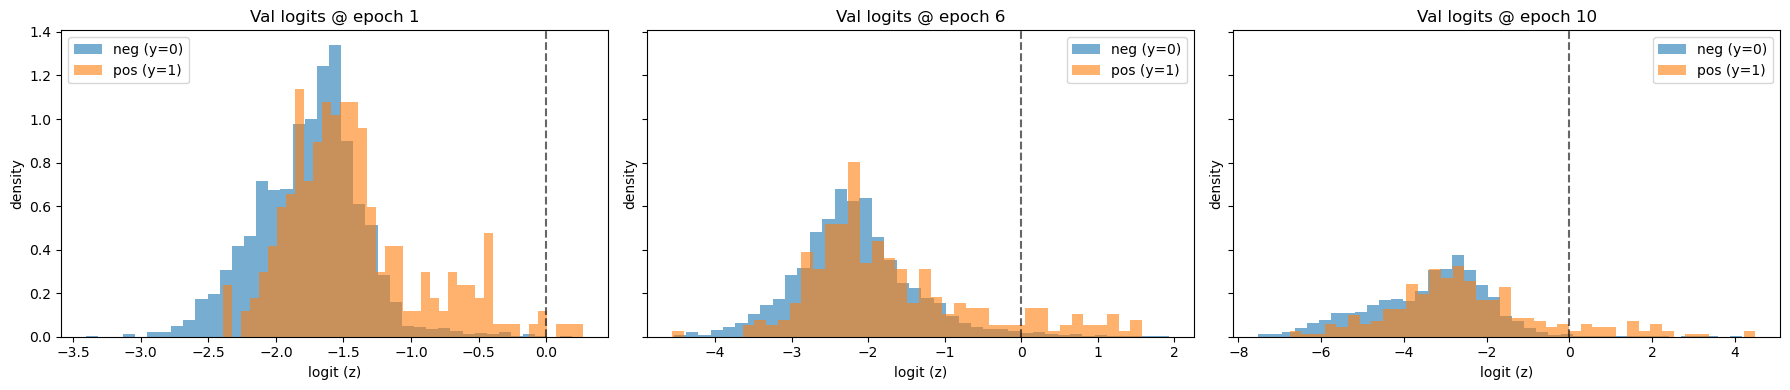

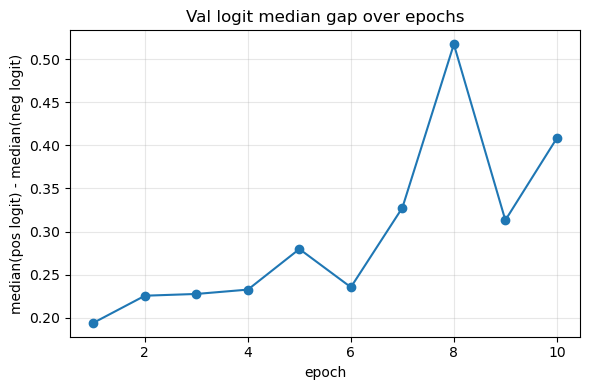

Train Loss,█▇▆▅▅▄▄▃▂▁
Val AUPR,▁██▇▇▇▅▇▇▇▆
Val AUROC,▁█▇▇▄▆▅▇▇▄▅
Val Loss,█▁▁▁▁▁▁▁▁▁▁
val_logit_gap,▁▂▂▂▃▂▄█▄▆
val_neg_median_logit,█▂▅▅▁▆▃▁▂▂
val_pos_median_logit,█▁▅▅▁▆▃▂▂▂
Train Loss,0.13504
Val AUPR,0.24428
Val AUROC,0.62429
Val Loss,0.37816


Training model b021a1c6-1cdb-4a80-a17e-9bf4c7120f1a
Before training - Val Loss 1.1235 | Val AUROC 0.6068 | Val AUPR 0.2373
EPOCH 1 - Train Loss 0.3360 | Val Loss 0.4724 | Val AUROC 0.5746 | Val AUPR 0.2050
EPOCH 2 - Train Loss 0.3008 | Val Loss 0.5065 | Val AUROC 0.4813 | Val AUPR 0.1712
EPOCH 3 - Train Loss 0.2946 | Val Loss 0.5166 | Val AUROC 0.4963 | Val AUPR 0.1631
EPOCH 4 - Train Loss 0.2923 | Val Loss 0.4846 | Val AUROC 0.5621 | Val AUPR 0.2285
EPOCH 5 - Train Loss 0.2767 | Val Loss 0.5196 | Val AUROC 0.5420 | Val AUPR 0.2168
EPOCH 6 - Train Loss 0.2729 | Val Loss 0.6648 | Val AUROC 0.4625 | Val AUPR 0.1690
EPOCH 7 - Train Loss 0.2567 | Val Loss 0.5996 | Val AUROC 0.4741 | Val AUPR 0.1880
EPOCH 8 - Train Loss 0.2356 | Val Loss 0.6277 | Val AUROC 0.4635 | Val AUPR 0.1855
EPOCH 9 - Train Loss 0.2112 | Val Loss 0.6410 | Val AUROC 0.5068 | Val AUPR 0.1753
EPOCH 10 - Train Loss 0.1894 | Val Loss 0.6063 | Val AUROC 0.5679 | Val AUPR 0.2480


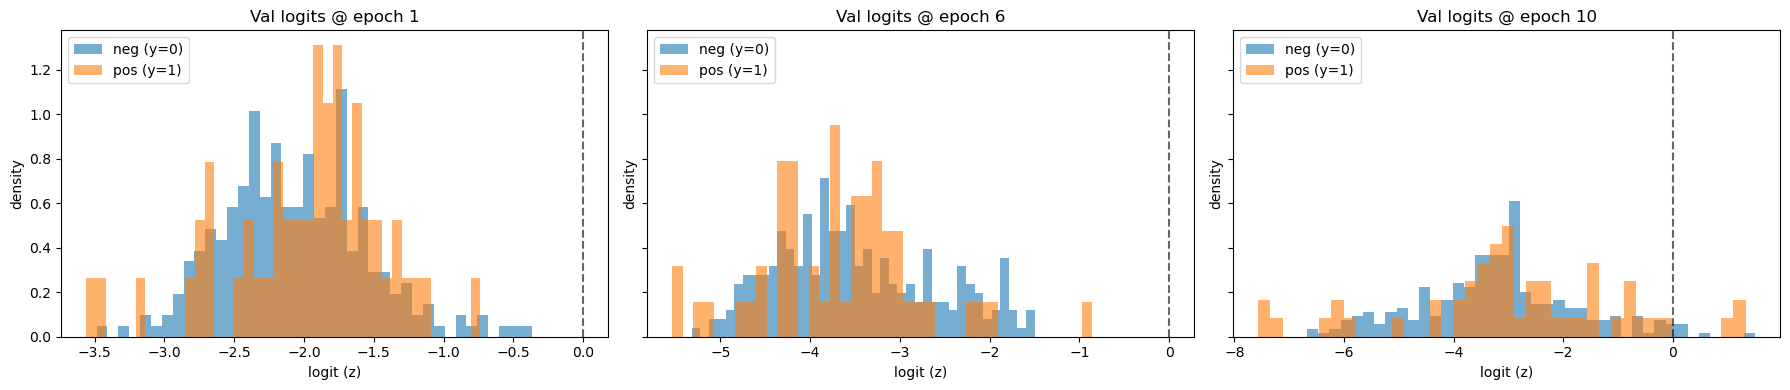

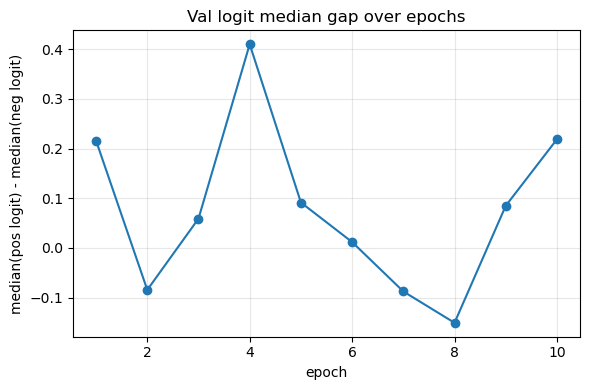

Train Loss,█▆▆▆▅▅▄▃▂▁
Val AUPR,▇▄▂▁▆▅▁▃▃▂█
Val AUROC,█▆▂▃▆▅▁▂▁▃▆
Val Loss,█▁▁▁▁▂▃▂▃▃▂
val_logit_gap,▆▂▄█▄▃▂▁▄▆
val_neg_median_logit,▇▆▇█▆▁▃▃▂▃
val_pos_median_logit,▇▅▆█▅▁▃▂▂▃
Train Loss,0.1894
Val AUPR,0.24804
Val AUROC,0.56792
Val Loss,0.60635


Training model b021a1c6-1cdb-4a80-a17e-9bf4c7120f1a
Before training - Val Loss 0.7139 | Val AUROC 0.6763 | Val AUPR 0.1795
EPOCH 1 - Train Loss 0.3534 | Val Loss 0.3380 | Val AUROC 0.6240 | Val AUPR 0.1737
EPOCH 2 - Train Loss 0.3105 | Val Loss 0.3327 | Val AUROC 0.6535 | Val AUPR 0.1831
EPOCH 3 - Train Loss 0.3019 | Val Loss 0.3701 | Val AUROC 0.5861 | Val AUPR 0.1366
EPOCH 4 - Train Loss 0.2947 | Val Loss 0.3782 | Val AUROC 0.5621 | Val AUPR 0.1427
EPOCH 5 - Train Loss 0.2831 | Val Loss 0.4026 | Val AUROC 0.5739 | Val AUPR 0.1435
EPOCH 6 - Train Loss 0.2685 | Val Loss 0.4159 | Val AUROC 0.6191 | Val AUPR 0.1632
EPOCH 7 - Train Loss 0.2487 | Val Loss 0.3579 | Val AUROC 0.5998 | Val AUPR 0.1699
EPOCH 8 - Train Loss 0.2286 | Val Loss 0.3685 | Val AUROC 0.5694 | Val AUPR 0.1335
EPOCH 9 - Train Loss 0.2032 | Val Loss 0.6494 | Val AUROC 0.5970 | Val AUPR 0.1431
EPOCH 10 - Train Loss 0.1676 | Val Loss 0.4699 | Val AUROC 0.5750 | Val AUPR 0.1436


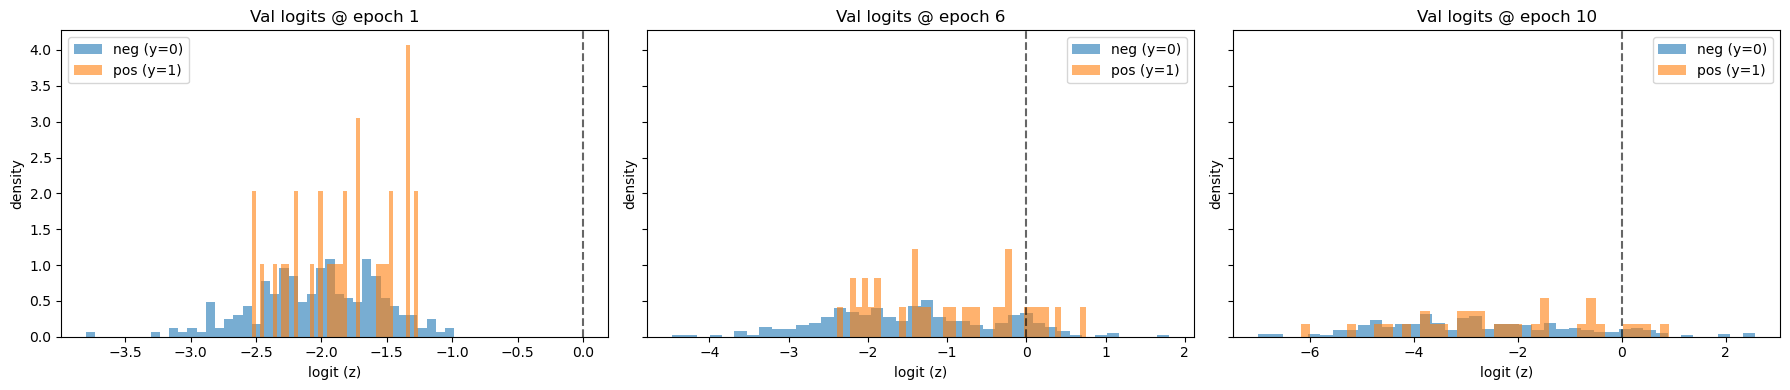

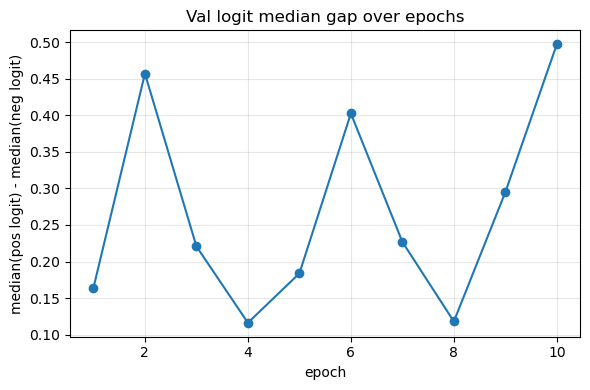

Train Loss,█▆▆▆▅▅▄▃▂▁
Val AUPR,▇▇█▁▂▂▅▆▁▂▂
Val AUROC,█▅▇▂▁▂▄▃▁▃▂
Val Loss,█▁▁▂▂▂▃▁▂▇▄
val_logit_gap,▂▇▃▁▂▆▃▁▄█
val_neg_median_logit,▄▃▅▆▆▆▄▄█▁
val_pos_median_logit,▃▃▅▅▆▆▃▃█▁
Train Loss,0.16762
Val AUPR,0.14356
Val AUROC,0.57504
Val Loss,0.46987


Training model b021a1c6-1cdb-4a80-a17e-9bf4c7120f1a
Before training - Val Loss 0.5591 | Val AUROC 0.5781 | Val AUPR 0.1247
EPOCH 1 - Train Loss 0.3644 | Val Loss 0.2729 | Val AUROC 0.5236 | Val AUPR 0.1068
EPOCH 2 - Train Loss 0.3279 | Val Loss 0.2922 | Val AUROC 0.5071 | Val AUPR 0.1031
EPOCH 3 - Train Loss 0.3215 | Val Loss 0.3949 | Val AUROC 0.5609 | Val AUPR 0.1082
EPOCH 4 - Train Loss 0.3037 | Val Loss 0.2945 | Val AUROC 0.5369 | Val AUPR 0.0772
EPOCH 5 - Train Loss 0.2929 | Val Loss 0.2830 | Val AUROC 0.5098 | Val AUPR 0.0725
EPOCH 6 - Train Loss 0.2786 | Val Loss 0.2932 | Val AUROC 0.4781 | Val AUPR 0.0676
EPOCH 7 - Train Loss 0.2606 | Val Loss 0.3042 | Val AUROC 0.5169 | Val AUPR 0.0700
EPOCH 8 - Train Loss 0.2406 | Val Loss 0.2933 | Val AUROC 0.5246 | Val AUPR 0.0864
EPOCH 9 - Train Loss 0.2311 | Val Loss 0.3176 | Val AUROC 0.4798 | Val AUPR 0.0947
EPOCH 10 - Train Loss 0.1884 | Val Loss 0.3205 | Val AUROC 0.4910 | Val AUPR 0.0788


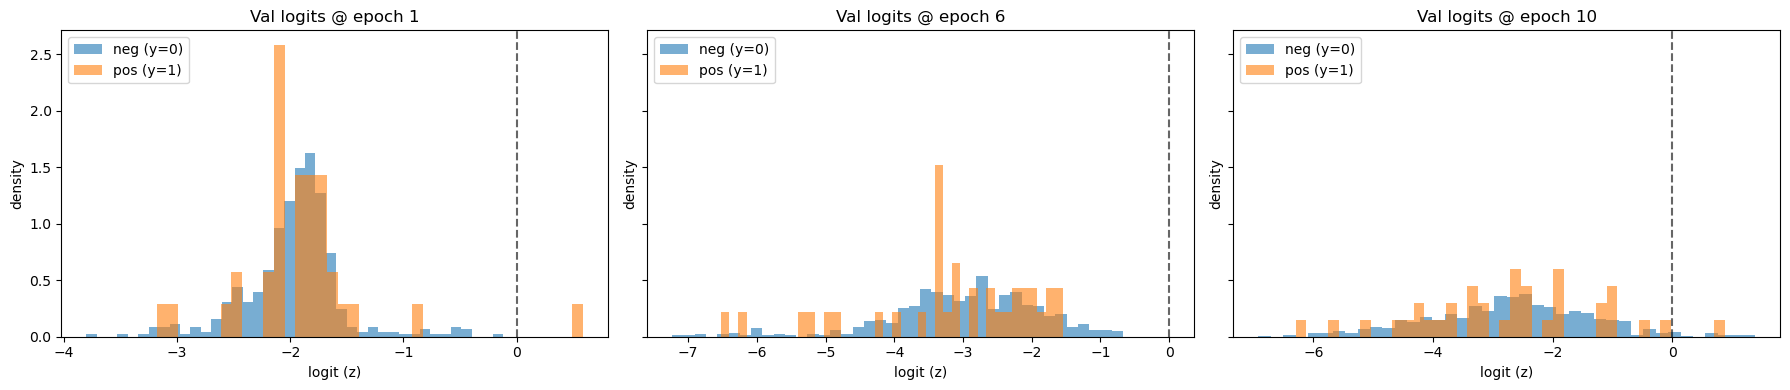

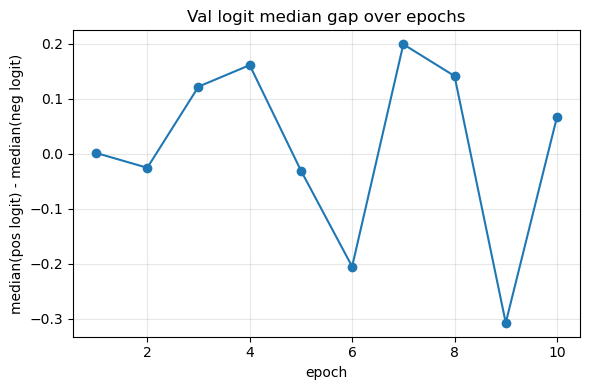

Train Loss,█▇▆▆▅▅▄▃▃▁
Val AUPR,█▆▅▆▂▂▁▁▃▄▂
Val AUROC,█▄▃▇▅▃▁▄▄▁▂
Val Loss,█▁▁▄▂▁▁▂▁▂▂
val_logit_gap,▅▅▇▇▅▂█▇▁▆
val_neg_median_logit,▆▆█▆▅▃▅▁▃▄
val_pos_median_logit,▅▆█▆▄▂▅▁▁▃
Train Loss,0.18839
Val AUPR,0.07881
Val AUROC,0.49095
Val Loss,0.32048


Training model b021a1c6-1cdb-4a80-a17e-9bf4c7120f1a
Before training - Val Loss 0.8023 | Val AUROC 0.5035 | Val AUPR 0.1242
EPOCH 1 - Train Loss 0.3451 | Val Loss 0.3316 | Val AUROC 0.4678 | Val AUPR 0.1164
EPOCH 2 - Train Loss 0.3099 | Val Loss 0.3239 | Val AUROC 0.5587 | Val AUPR 0.1811
EPOCH 3 - Train Loss 0.3029 | Val Loss 0.3479 | Val AUROC 0.4895 | Val AUPR 0.1519
EPOCH 4 - Train Loss 0.2972 | Val Loss 0.3335 | Val AUROC 0.5408 | Val AUPR 0.1394
EPOCH 5 - Train Loss 0.2761 | Val Loss 0.3508 | Val AUROC 0.5218 | Val AUPR 0.1417
EPOCH 6 - Train Loss 0.2627 | Val Loss 0.3784 | Val AUROC 0.5194 | Val AUPR 0.1325
EPOCH 7 - Train Loss 0.2486 | Val Loss 0.3363 | Val AUROC 0.5361 | Val AUPR 0.1482
EPOCH 8 - Train Loss 0.2357 | Val Loss 0.3587 | Val AUROC 0.5769 | Val AUPR 0.1475
EPOCH 9 - Train Loss 0.2029 | Val Loss 0.4161 | Val AUROC 0.5404 | Val AUPR 0.1446
EPOCH 10 - Train Loss 0.1683 | Val Loss 0.5160 | Val AUROC 0.5047 | Val AUPR 0.1913


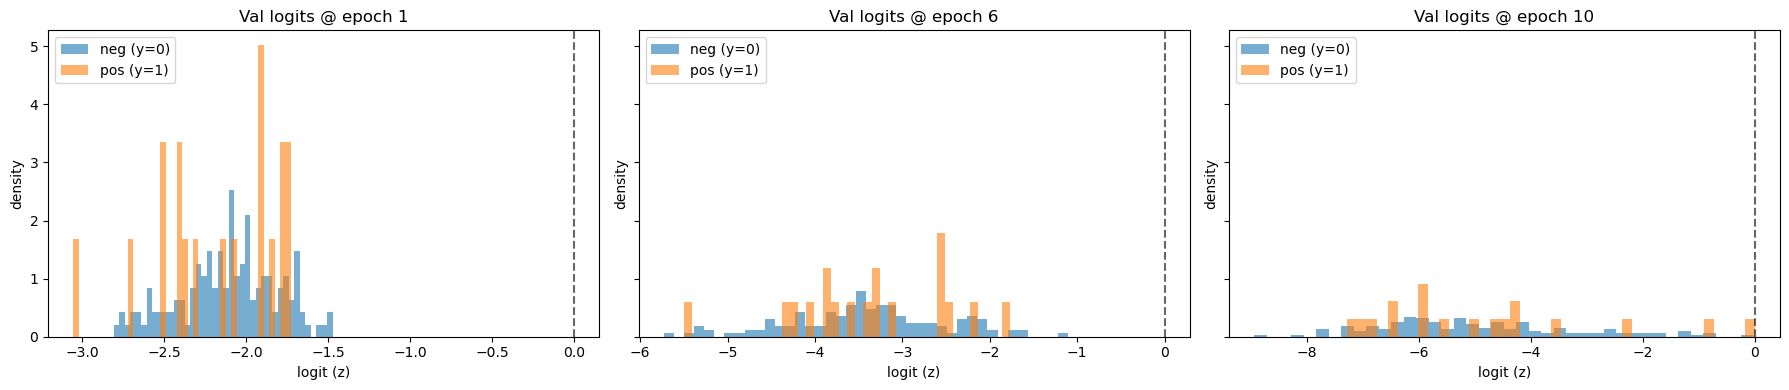

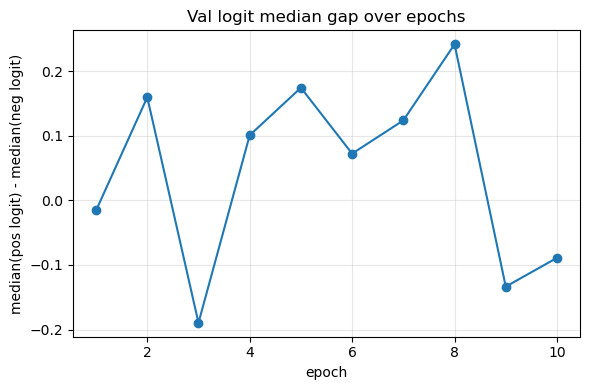

Train Loss,█▇▆▆▅▅▄▄▂▁
Val AUPR,▂▁▇▄▃▃▃▄▄▄█
Val AUROC,▃▁▇▂▆▄▄▅█▆▃
Val Loss,█▁▁▁▁▁▂▁▂▂▄
val_logit_gap,▄▇▁▆▇▅▆█▂▃
val_neg_median_logit,█▇▆▇▆▅█▆▄▁
val_pos_median_logit,█▇▆▇▆▅█▇▃▁
Train Loss,0.16828
Val AUPR,0.19133
Val AUROC,0.50466
Val Loss,0.51596


In [22]:
batch_size = 20
learning_rate = 2e-5
EPOCHS = 10

all_binders = interaction_df["target_binder_ID"].tolist()

# all dataset: binder_enb, target_emb, label
ALL_btl = binder_target_label(targets_dataset, binders_dataset, all_binders, interaction_df)

class PairListDataset(Dataset):
    def __init__(self, examples, weights=None):
        self.examples = examples
        
    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        b = torch.as_tensor(b, dtype=torch.float32)
        t = torch.as_tensor(t, dtype=torch.float32)
        y = torch.tensor(float(y), dtype=torch.float32)
        return b, t, y

# login once (env var preferred)
if use_wandb:
    import wandb
    wandb.login()

ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
# model.train()

for i in range(len(cv_splits)):
    # NEW model per split
    model = MiniCLIP_w_transformer_crossattn()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    val_targets = cv_splits[i][0]
    val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
    val_binders = [ALL_btl[idx] for idx in val_idx]

    train_targets = cv_splits[i][1]
    train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
    train_binders = [ALL_btl[idx] for idx in train_idx]

    # loaders
    train_loader   = DataLoader(train_binders,   batch_size=20, shuffle=True, generator = torch.Generator().manual_seed(0))
    val_loader   = DataLoader(val_binders,   batch_size=20, shuffle=False, drop_last = False)

    # accelerator
    accelerator = Accelerator()
    device = accelerator.device
    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    # wandb
    if use_wandb:
        run = wandb.init(
            project="CLIP_PPint_metaanalysis_noweighting",
            name=f"split{i+1}_{runID}",
            group="cv_splits",
            config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
                    "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
        )
        wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
    else:
        run = None

    # train
    training_wrapper = TrainWrapper_MetaAnal(
        model=model,
        training_loader=train_loader,
        validation_loader=val_loader,
        test_dataset=val_binders,   # ok if you truly want “full val”
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        runID=runID,
        device=device,
        model_save_steps=model_save_steps,
        model_save_path=trained_model_dir,
        v=True,
        wandb_tracker=run,
        split_id=i+1
    )
    training_wrapper.train_model()

    # cleanup between splits
    if use_wandb:
        wandb.finish()
    del training_wrapper, model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    try:
        accelerator.free_memory()
    except AttributeError:
        pass

### Pairwise Welch’s t-tests between folds (for both AUROC and AUPR) and applies a Bonferroni correction for multiple testing

In [2]:
metrics = {
    "Fold1": {
        "auroc": [0.5554, 0.6786, 0.6621, 0.6638, 0.6145, 0.6484, 0.6237, 0.6548, 0.6666, 0.6135, 0.6243],
        "aupr":  [0.1251, 0.2782, 0.2725, 0.2662, 0.2538, 0.2571, 0.2213, 0.2587, 0.2638, 0.2483, 0.2443],
    },
    "Fold2": {
        "auroc": [0.6068, 0.5746, 0.4813, 0.4963, 0.5621, 0.5420, 0.4625, 0.4741, 0.4635, 0.5068, 0.5679],
        "aupr":  [0.2373, 0.2050, 0.1712, 0.1631, 0.2285, 0.2168, 0.1690, 0.1880, 0.1855, 0.1753, 0.2480],
    },
    "Fold3": {
        "auroc": [0.6763, 0.6240, 0.6535, 0.5861, 0.5621, 0.5739, 0.6191, 0.5998, 0.5694, 0.5970, 0.5750],
        "aupr":  [0.1795, 0.1737, 0.1831, 0.1366, 0.1427, 0.1435, 0.1632, 0.1699, 0.1335, 0.1431, 0.1436],
    },
    "Fold4": {
        "auroc": [0.5781, 0.5236, 0.5071, 0.5609, 0.5369, 0.5098, 0.4781, 0.5169, 0.5246, 0.4798, 0.4910],
        "aupr":  [0.1247, 0.1068, 0.1031, 0.1082, 0.0772, 0.0725, 0.0676, 0.0700, 0.0864, 0.0947, 0.0788],
    },
    "Fold5": {
        "auroc": [0.5035, 0.4678, 0.5587, 0.4895, 0.5408, 0.5218, 0.5194, 0.5361, 0.5769, 0.5404, 0.5047],
        "aupr":  [0.1242, 0.1164, 0.1811, 0.1519, 0.1394, 0.1417, 0.1325, 0.1482, 0.1475, 0.1446, 0.1913],
    },
}


In [4]:
import itertools
from scipy.stats import ttest_ind

# --- plug in your metrics dict here ---
# metrics = { "Fold1": {"auroc": [...], "aupr": [...]}, ... }

def pairwise_ttests_with_bonferroni(metrics, key="auroc", alpha=0.05):
    """
    Pairwise Welch's t-tests across folds for the given metric key ('auroc' or 'aupr'),
    with Bonferroni correction.
    Returns a DataFrame with raw and adjusted p-values and a significance flag.
    """
    folds = sorted(metrics.keys())
    combos = list(itertools.combinations(folds, 2))
    m = len(combos)  # number of tests for Bonferroni

    rows = []
    for a, b in combos:
        xa = np.asarray(metrics[a][key], dtype=float)
        xb = np.asarray(metrics[b][key], dtype=float)

        # Welch's t-test (doesn't assume equal variances)
        t_stat, p_raw = ttest_ind(xa, xb, equal_var=False)

        # Bonferroni adjustment
        p_adj = min(p_raw * m, 1.0)
        rows.append({
            "metric": key,
            "fold_a": a,
            "fold_b": b,
            "t_stat": t_stat,
            "p_raw": p_raw,
            "p_bonf": p_adj,
            "significant_(bonf)": p_adj < alpha
        })

    return pd.DataFrame(rows).sort_values(["metric", "p_bonf", "fold_a", "fold_b"]).reset_index(drop=True)

# Run for AUROC and AUPR
auroc_results = pairwise_ttests_with_bonferroni(metrics, key="auroc", alpha=0.05)
aupr_results  = pairwise_ttests_with_bonferroni(metrics, key="aupr",  alpha=0.05)

print("=== AUROC pairwise t-tests (Bonferroni) ===")
print(auroc_results.to_string(index=False))
print("\n=== AUPR pairwise t-tests (Bonferroni) ===")
print(aupr_results.to_string(index=False))

=== AUROC pairwise t-tests (Bonferroni) ===
metric fold_a fold_b    t_stat        p_raw       p_bonf  significant_(bonf)
 auroc  Fold1  Fold4  8.292943 7.376758e-08 7.376758e-07                True
 auroc  Fold1  Fold5  7.952136 1.404805e-07 1.404805e-06                True
 auroc  Fold1  Fold2  6.174029 8.275148e-06 8.275148e-05                True
 auroc  Fold3  Fold4  5.813856 1.195153e-05 1.195153e-04                True
 auroc  Fold3  Fold5  5.481117 2.485774e-05 2.485774e-04                True
 auroc  Fold2  Fold3 -4.322490 4.026001e-04 4.026001e-03                True
 auroc  Fold1  Fold3  2.191496 4.043860e-02 4.043860e-01               False
 auroc  Fold2  Fold4  0.156892 8.772167e-01 1.000000e+00               False
 auroc  Fold2  Fold5 -0.109440 9.141613e-01 1.000000e+00               False
 auroc  Fold4  Fold5 -0.358579 7.236670e-01 1.000000e+00               False

=== AUPR pairwise t-tests (Bonferroni) ===
metric fold_a fold_b    t_stat        p_raw       p_bonf  signifi